# Variational Autoencoder

## Import the libraries

In [1]:
import keras
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
%matplotlib inline

from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, add
from keras.objectives import binary_crossentropy
from keras.layers.core import Layer, Dense, Dropout, Activation, Flatten, Reshape
from keras.utils import np_utils
from keras import backend as K
from keras import metrics
from keras.layers.core import Lambda

## Load the data

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

## Normalize the data

we want the pixels values between 0 and 1 instead of between 0 and 255

In [4]:
X_train = X_train.astype("float32")/255.
X_test = X_test.astype("float32")/255.

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


## Flatten the images for the Fully-Connected Networks

In [5]:
X_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
X_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))

# Simple Autoencoder

## Create the network

In [6]:
input_size = 784
hidden_size = 32
code_size = 2

x = Input(shape=(input_size,))
hidden_1 = Dense(hidden_size, activation='relu')(x)
h = Dense(code_size)(hidden_1)
hidden_2 = Dense(hidden_size, activation='relu')(h)
r = Dense(input_size, activation='sigmoid')(hidden_2)

autoencoder = Model(inputs=x, outputs=r)

Instructions for updating:
Colocations handled automatically by placer.


In [7]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

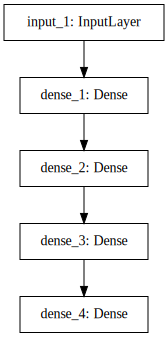

In [8]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(autoencoder).create(prog='dot', format='svg'))

## Train the network

In [9]:
epochs = 50
batch_size = 128

In [10]:
history = autoencoder.fit(X_train, X_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_test, X_test))

Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 6s 104us/step - loss: 0.2840 - val_loss: 0.2389
Epoch 2/50
60000/60000 [==============================] - 5s 90us/step - loss: 0.2329 - val_loss: 0.2261
Epoch 3/50
60000/60000 [==============================] - 5s 91us/step - loss: 0.2235 - val_loss: 0.2188
Epoch 4/50
60000/60000 [==============================] - 5s 91us/step - loss: 0.2179 - val_loss: 0.2145
Epoch 5/50
60000/60000 [==============================] - 5s 89us/step - loss: 0.2135 - val_loss: 0.2109
Epoch 6/50
60000/60000 [==============================] - 5s 89us/step - loss: 0.2094 - val_loss: 0.2076
Epoch 7/50
60000/60000 [==============================] - 5s 89us/step - loss: 0.2066 - val_loss: 0.2052
Epoch 8/50
60000/60000 [==============================] - 5s 89us/step - loss: 0.2044 - val_loss: 0.2033
Epoch 9/50
60000/60000 [==============================] - 5s 

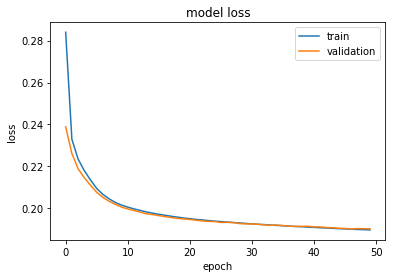

In [11]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

## Plot the 2D Latent representation

In [12]:
encoder = Model(x, h)

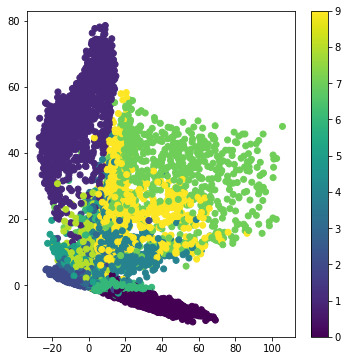

In [13]:
x_test_encoded = encoder.predict(X_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

# Variational Autoencoder

In [14]:
original_dim = 784
latent_dim = 2
intermediate_dim = 256
epsilon_std = 1.0

In [15]:
x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

In [16]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [17]:
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

In [18]:
def vae_loss(x, x_decoded_mean):
    xent_loss = original_dim * binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return K.mean(xent_loss + kl_loss)

In [19]:
vae = Model(x, x_decoded_mean)
vae.compile(optimizer='rmsprop', loss = vae_loss)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 256)          200960      input_2[0][0]                    
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 2)            514         dense_5[0][0]                    
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 2)            514         dense_5[0][0]                    
__________________________________________________________________________________________________
lambda_1 (

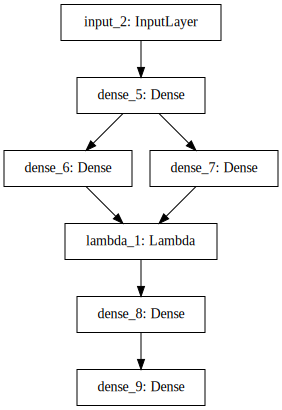

In [20]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(vae).create(prog='dot', format='svg'))

In [21]:
history = vae.fit(X_train, X_train,shuffle=True, epochs=epochs, batch_size=batch_size, validation_data=(X_test, X_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 12s 193us/step - loss: 194.4967 - val_loss: 174.3686
Epoch 2/50
60000/60000 [==============================] - 11s 181us/step - loss: 172.1773 - val_loss: 169.4217
Epoch 3/50
60000/60000 [==============================] - 10s 164us/step - loss: 168.6508 - val_loss: 166.7588
Epoch 4/50
60000/60000 [==============================] - 9s 142us/step - loss: 166.3066 - val_loss: 165.3562
Epoch 5/50
60000/60000 [==============================] - 9s 144us/step - loss: 164.5064 - val_loss: 163.6073
Epoch 6/50
60000/60000 [==============================] - 8s 138us/step - loss: 163.1111 - val_loss: 162.2746
Epoch 7/50
60000/60000 [==============================] - 7s 120us/step - loss: 162.0124 - val_loss: 161.8879
Epoch 8/50
60000/60000 [==============================] - 9s 151us/step - loss: 161.0504 - val_loss: 160.6685
Epoch 9/50
60000/60000 [==============================] - 8s 137us/

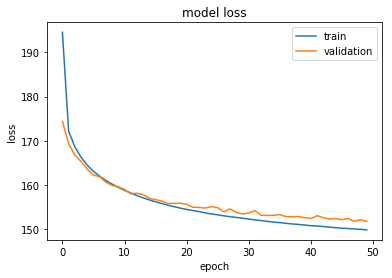

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

## Plot the 2D latent representation

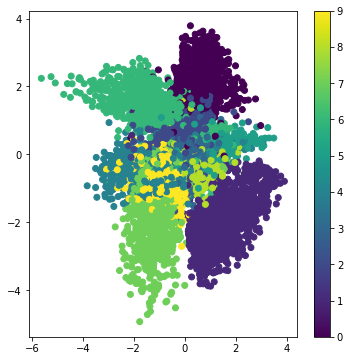

In [23]:
# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(X_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

In [24]:
# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

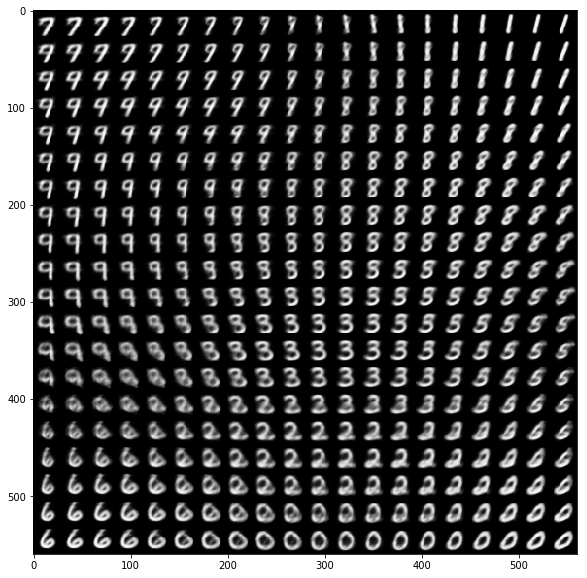

In [25]:

# display a 2D manifold of the digits
n = 20  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()